Project 2: Sequence Labeling (100 Points)
=======================

- This problem set, again based in part on one by Jacob Eisenstein, focuses on sequence labeling with Hidden Markov models and Deep Learning Models.
- The target domain is part-of-speech tagging on English and Norwegian from the Universal Dependencies dataset.

You will:
- Do some basic preprocessing of the data
- Build a naive classifier that tags each word with its most common tag
- Implement a `Viterbi` Tagger using `Hidden Markov Model` in PyTorch
- Build a `Bi-LSTM` deep learning model using PyTorch
- Implement techniques to improve your classifier and compete with your classmates.


# 0. Setup

In order to develop this assignment, you will need [python 3.6](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [anaconda](https://www.continuum.io/downloads), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- [numpy](https://docs.scipy.org/doc/numpy/user/install.html)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```oswegonlp```.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, run the script ```make-submission.sh```, and submit the tarball ```project2-submission.tgz``` on Blackboard.**

In [2]:
import sys
from importlib import reload

In [3]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [4]:
import nose

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [5]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 1.1.4
numpy: 1.16.2
matplotlib: 3.1.1
nose: 1.3.7
torch: 1.8.1+cu102


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [6]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


In [7]:
from collections import defaultdict, Counter

# importing all the necessary files from oswegonlp
from oswegonlp import constants, preprocessing, most_common, classifier_base, evaluation
from oswegonlp import scorer, tagger_base, naive_bayes, hmm, viterbi, bilstm, cbow

# 1. Data Processing
The part-of-speech tags are defined on the [universal dependencies website](http://universaldependencies.org/en/pos/index.html).

In [8]:
reload(constants);
## Define the file names
TRAIN_FILE = constants.TRAIN_FILE
DEV_FILE = constants.DEV_FILE
TEST_FILE = constants.TEST_FILE 
TEST_FILE_HIDDEN = constants.TEST_FILE_UNLABELED
NR_TRAIN_FILE = constants.NR_TRAIN_FILE
NR_DEV_FILE = constants.NR_DEV_FILE
NR_TEST_FILE = constants.NR_TEST_FILE
NR_TEST_FILE_HIDDEN = constants.NR_TEST_FILE_UNLABELED

- Here is demo code for using the function `conll_seq_generator(...)`. 
- The default value for max_insts is `1000000` indicating the num. of instances: and this should be enough for our dataset. 

In [9]:
## Demo
all_tags = set([])
for (words, tags) in preprocessing.conll_seq_generator(TRAIN_FILE):
    for tag in tags:
        all_tags.add(tag)
all_tags = sorted(all_tags)
print (all_tags)

['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


**Deliverable 1.1**: Counting words per tag. (*10 points*)

Implement the function `get_tag_word_counts` in `most_common.py`: The function should calculate the number of occurrences of all words for each tag.

- **Input**: filename for data file, to be passed as argument to `preprocessing.conll_seq_generation`
- **Output**: dict of counters, where keys are tags
- **Tests**: ```test_most_common.py: test_get_top_noun_tags(),test_get_top_verb_tags()```

In [10]:
reload(most_common);

In [11]:
# this block uses your code to find the three most common words per tag
counters = most_common.get_tag_word_counts(TRAIN_FILE)
for tag,tag_ctr in counters.items():
    print (tag,tag_ctr.most_common(3))

PROPN [('Bush', 211), ('US', 162), ('Iraq', 119)]
PUNCT [('.', 8640), (',', 7021), ('-', 1314)]
ADJ [('other', 268), ('good', 251), ('new', 195)]
NOUN [('time', 385), ('people', 233), ('way', 187)]
VERB [('have', 749), ('get', 359), ('know', 338)]
DET [('the', 8141), ('a', 3589), ('The', 884)]
ADP [('of', 3424), ('in', 2705), ('to', 1783)]
AUX [('is', 1865), ('was', 1123), ('be', 1053)]
PRON [('I', 3121), ('you', 1920), ('it', 1468)]
PART [('to', 3221), ('not', 805), ("n't", 645)]
SCONJ [('that', 983), ('if', 453), ('as', 312)]
NUM [('one', 329), ('two', 157), ('2', 129)]
ADV [('so', 371), ('just', 353), ('when', 306)]
CCONJ [('and', 4843), ('or', 698), ('but', 600)]
X [('etc', 39), ('1', 29), ('2', 29)]
INTJ [('Please', 141), ('please', 111), ('Yes', 34)]
SYM [('$', 251), ('-', 101), ('#', 37)]


# 2. Tagging as classification 

Now you will implement part-of-speech tagging via classification.

Tagging quality is evaluated using evalTagger, which takes three arguments:
- a tagger, which is a **function** taking a list of words and a tagset as arguments and returns the predicted tags for the words
- an output filename
- a test file

You will want to use lambda expressions to create the first argument for the `eval_tagger(..)` function, as shown below.
Here's how it works. I provide a tagger that labels everything as a noun.

In [12]:
reload(tagger_base);

In [13]:
# here is a tagger that just tags everything as a noun
noun_tagger = lambda words, alltags : ['NOUN' for word in words]

confusion = tagger_base.eval_tagger(noun_tagger,'nouns.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.16667992047713717


**Deliverable 2.1** Classification-based tagging. (*5 points*)

Now do the same thing as above, but building your tagger *as a classifier.* To do this, implement `make_classifier_tagger()` in `tagger_base.py`. 

- **Input**: defaultdict of weights
- **Output**: return a function that takes in (list of word tokens, list of all possible tags) $\rightarrow$ tags for each word

The function that you output should create the base-features for each token (**use the OFFSET and the TOKEN itself as base-features**)  and then use your `classifier_base.predict()` function from project 1. You are free to edit the `classifier_base.predict()` function if you don't think you got it right in project 1.
- **Tests**: ```test_classifier_tagger.py:test_classifier()```


In [14]:
reload(tagger_base);
reload(classifier_base);
from oswegonlp.constants import OFFSET #OFFSET token is for each tag

- Now create a tagger with weights that predict every token to be a NOUN. 
The function `get_noun_weights` is already implemented for you.

In [15]:
classifier_noun_tagger = tagger_base.make_classifier_tagger(most_common.get_noun_weights())

In [16]:
confusion = tagger_base.eval_tagger(classifier_noun_tagger,'all-nouns.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.16667992047713717


**Deliverable 2.2** Tagging words by their most common tag. (*5 points*)

Now build a classifier tagger that tags each word with its most common tag in the training set. To do this, implement `get_most_common_word_weights` in `most_common.py`.  

- **Input**: training file

- **Output**: defaultdict of weights

This function should return a set weights such that each word should get the tag that is most frequently associated with it in the training data. If the word does not appear in the training data, the weights should be set so that the tagger outputs the **most common tag** in the training data. For the out of vocabulary words, you need to think on how to set the weights so that you tag them by the most common tag.

- **Tests**: ```test_classifier.py:test_mcc_tagger_output(), test_mcc_tagger_accuracy()```

In [17]:
reload(most_common);
theta_mc = most_common.get_most_common_word_weights(TRAIN_FILE)

In [18]:
tagger_mc = tagger_base.make_classifier_tagger(theta_mc)

In [19]:
tags = tagger_mc(['They','can','can','fish'],all_tags)
print (tags)

['PRON', 'AUX', 'AUX', 'NOUN']


In [20]:
tags = tagger_mc(['The','old','man','the','boat','.'],all_tags)
print (tags)

['DET', 'ADJ', 'NOUN', 'DET', 'NOUN', 'PUNCT']


- Now let's run your tagger on the dev data.

In [21]:
confusion = tagger_base.eval_tagger(tagger_mc,'most-common.preds',all_tags=all_tags)
print (scorer.accuracy(confusion))

0.8559443339960239


### Naive Bayes as a tagger.
    
- You can use your Naive Bayes classifier form project 1 to set the weights for the classifier tagger. I have added a helper function `naive_bayes.get_nb_weights(..)`. Make sure to retain this function, when you copy your code.
- If you don't think you got it right in project 1, you are free to change it now. If you got it right, then just examine the performance of naive bayes as tagger in the following blocks. There is no test or deliverable for this part.
- Note that, for text classification, we had a bag of words feature vector and label for each document. For POS tagging, in order to estimate the weights for the classifier tagger, we will consider each token to be its own document. The following helper code converts the dataset to token level bag-of-words feature vector and labels.


In [22]:
reload(naive_bayes);
nb_weights = naive_bayes.get_nb_weights(TRAIN_FILE, .01)

This gives weights for each tag-word pair that represent $\log P(word \mid tag)$

In [23]:
# obtaining vocab of words
vocab = set([word for tag,word in nb_weights.keys() if word is not constants.OFFSET])

In [24]:
print (len(vocab))

19672


In [25]:
print (sum(np.exp(nb_weights[('ADJ',word)]) for word in vocab))
print (sum(np.exp(nb_weights[('NOUN',word)]) for word in vocab))
print (sum(np.exp(nb_weights[('PUNCT',word)]) for word in vocab))

0.9999999999996653
1.0000000000002178
0.9999999999999724


We have zero weights for OOV terms -- think about how this affects the classification here!

In [26]:
print (nb_weights[('ADJ','baaaaaaaaad')])

0.0


In [27]:
print (nb_weights[('VERB',constants.OFFSET)])
print (nb_weights[('ADV',constants.OFFSET)])
print (nb_weights[('PRON',constants.OFFSET)])

-2.184346549553986
-2.964122263995488
-2.3990689301958317


Offsets should correspond to log-probabilities $\log P(y)$ such that $\sum_y P(y) = 1$.

In [28]:
sum(np.exp(nb_weights[(tag,constants.OFFSET)]) for tag in all_tags)

1.0000000000000002

Now let us look at the accuracy of our naive_bayes tagger.

In [29]:
confusion = tagger_base.eval_tagger(tagger_base.make_classifier_tagger(nb_weights),'nb-simple.preds')
dev_acc = scorer.accuracy(confusion)
print (dev_acc)

0.8424254473161034


Notice it's just about as good as the heuristic tagger from above.

# 3. Viterbi Algorithm

In this section you will implement the Viterbi algorithm in **PyTorch**. To get warmed up, let's work out an example by hand. For simplicity, there are only two tags, **N**OUN and **V**ERB. Here are the parameters:

| | Value |
| ------------- |:-------------:|
| $\log P_E(\cdot|N)$ | they: -1, can: -3, fish: -3 |
| $\log P_E(\cdot|V)$ | they: -11, can: -2, fish: -4 |
| $\log P_T(\cdot|N)$ | N: -5, V: -2, END: -2 |
| $\log P_T(\cdot|V)$ | N: -1, V: -3, END: -3 |
| $\log P_T(\cdot|\text{START})$ | N :-1, V :-2 |

where $P_E(\cdot|\cdot)$ is the emission probability and $P_T(\cdot|\cdot)$ is the transition probability.
 
- In class we discussed the sentence *They can fish*. 
- Now work out a more complicated example: "*They can can fish*", where the second "*can*" refers to the verb of putting things into cans.
 
**Deliverable 3.1** Work out the trellis by hand, and fill in the table in the file **```text-answers.md```** (*5 points*)

## Implementing Viterbi ##

Here are some predefined weights, corresponding to the weights from the problem 3.1.

In [30]:
START_TAG = constants.START_TAG
END_TAG = constants.END_TAG
UNK = constants.UNK

nb_weights={('NOUN','they'):-1,\
            ('NOUN','can'):-3,\
            ('NOUN','fish'):-3,\
            ('VERB','they'):-11,\
            ('VERB','can'):-2,\
            ('VERB','fish'):-4,}
hmm_trans_weights={('NOUN','NOUN'):-5,\
                   ('VERB','NOUN'):-2,\
                   (END_TAG,'NOUN'):-2,\
                   ('NOUN','VERB'):-1,\
                   ('VERB','VERB'):-3,\
                   (END_TAG,'VERB'):-3,\
                   ('NOUN',START_TAG):-1,\
                   ('VERB',START_TAG):-2}

**Deliverable 3.2** Complete the ```hmm.compute_weights_variables(...)``` function in `hmm.py` file (*5 points*).

The function should basically convert the weights to respective pytorch variables .

- **Inputs** :
    - `nb_weights`: emission_weights: dictionary of weights
    - `hmm_trans_weights`: dictionary of weights
    - `vocab`: list of all the words
    - `word_to_ix`: a dictionary that maps each word in the vocab to a unique index. **Does not have the OFFSET_TOKEN.**
    - `tag_to_ix`: a dictionary that maps each tag (including the `START_TAG` and the `END_TAG`) to a unique index.  

- **Outputs** : returns two torch Variables
    - `emission_probs`: torch Variable of a matrix of size `Vocab x Tagset_size`: 
        such that for a specific weight say `(word1, tag1):value` would result in
        `emission_probs[word_to_ix[word1]][tag_to_ix[tag1]]=value`, else a zero. Also, make sure to set weights such that `START_TAG` and `END_TAG` cannot generate any word. **Make sure to ignore the OFFSET weights that might be present in the nb_weights. Consider the words only in your word_to_ix.**
        
    - `tag_transition_probs`: torch Variable of a matrix of size `Tagset_size x Tagset_size`: 
        such that for a specific feature say `(tag1, tag2):value` 
        where tag1 is my succeeding tag, tag2 is my current tag. 
        This would result in `tag_transition_probs[tag_to_ix[tag1]][tag_to_ix[tag2]]=value`. 
        Also be sure to set the other weights such that there are no illegal transitions 
        (like from some tag to START_TAG -or- from END_TAG to some other tag)  

- **Tests**: ```test_viterbi.py: test_compute_hmm_weights_variables()```

Hint: Use `-np.inf` as weights for illegal transitions.

- Below, observe that we are calculating `tag_to_ix, ix_to_tag, word_to_ix`. These are useful to access a particular emission score for a particular token and a tag. Look through the variables: tag_transition_probs and emission_probs below and it should be clear.

In [31]:
reload(hmm);
word_to_ix={'they':0, 'can':1, 'fish':2, UNK:3}
tag_to_ix = {START_TAG:0, 'NOUN':1, 'VERB':2, END_TAG:3}
ix_to_tag = {v:k for k,v in tag_to_ix.items()}
all_tags = [START_TAG, 'NOUN', 'VERB', END_TAG]
words = ['they', 'can', 'fish']
vocab = ['they','can','fish',UNK]
# note that we are also including an UNK token: this will be helpful later

In [32]:
emission_probs, tag_transition_probs = hmm.compute_weights_variables(nb_weights, hmm_trans_weights, vocab, 
                                                                     word_to_ix, tag_to_ix)

In [33]:
print (tag_transition_probs)
# tag_transition_probs[0] corresponds to scores for START_TAG from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[1] corresponds to scores for NOUN from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[2] corresponds to scores for VERB from START_TAG, NOUN, VERB, END_TAG
# tag_transition_probs[3] corresponds to scores for END_TAG from START_TAG, NOUN, VERB, END_TAG

tensor([[-inf, -inf, -inf, -inf],
        [-1., -5., -1., -inf],
        [-2., -2., -3., -inf],
        [-inf, -2., -3., -inf]])


In [34]:
print (emission_probs)
# emission_probs[0] corresponds to scores for the token 'they' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[1] corresponds to scores for the token 'can' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[2] corresponds to scores for the token 'fish' for START_TAG, NOUN, VERB, END_TAG
# emission_probs[2] corresponds to scores for the token 'UNK' for START_TAG, NOUN, VERB, END_TAG

tensor([[-inf,  -1., -11., -inf],
        [-inf,  -3.,  -2., -inf],
        [-inf,  -3.,  -4., -inf],
        [-inf,   0.,   0., -inf]])


- we will be using these emission scores as inputs for each token in the input in the following function: ```viterbi_step()```.

**Deliverable 3.3** The Viterbi recurrence. (*10 points*)

Implement `viterbi_step` in `oswegonlp/viterbi.py`. This is the function that will compute the best path score and corresponding back pointer for a particular token in the sentence for all possible tags, which you will later call from the main viterbi routine. 

### Inputs
- `all_tags`: list of all tags: includes both the `START_TAG` and the `END_TAG`
- `tag_to_ix`: a dictionary that maps each tag (including the `START_TAG` and the `END_TAG`) to a unique index: this is useful to access the respective tag transition scores from the tag_transition_probs variable.
- `cur_tag_scores`: pytorch Variable that contains the local emission score for each tag for the current token in the sentence.
    - `cur_tag_scores` size is : `[ len(all_tags) ] `
- `transition_scores`: pytorch Variable that contains the `tag_transition_scores`. 
    - `transition_scores` size is : `[ len(all_tags) x len(all_tags) ]` 
- `prev_scores`: pytorch Variable that contains the scores for each tag for the previous token in the sentence.
    - `prev_scores` size is : `[ 1 x len(all_tags) ] `

### Outputs
- `viterbivars`: a pytorch Variable that contains the global scores for each tag for the current token in the sentence
- `bptrs`: a list of idx that contains the best_previous_tag for each tag for the current token in the sentence

### Tests
- ```test_viterbi.py: test_viterbi_step_init()```  

There are a lot of inputs, but the code itself will not be very complex. Make sure you understand what each input represents before starting to write a solution.

**Do not convert the pytorch variables into numpy.**

- Consider the sentence: `'they can can fish'`
- Let us observe the viterbi scores at each of the tokens 'they', 'can', 'can', 'fish'.
- We will walk through this example and all along: these scores should match with the scores you obtained when you worked it out by hand.
- **Please note the dimensions of the tensors below**

In [35]:
reload(viterbi);
initial_vec = np.full((1, len(all_tags)),-np.inf) 
initial_vec[tag_to_ix[START_TAG]][0] = 0 #setting all the score to START_TAG
prev_scores = viterbi.get_torch_variable(initial_vec)
# these are the previous scores for each_tag: START_TAG, NOUN, VERB, END_TAG
print (prev_scores)

tensor([[0., -inf, -inf, -inf]])


- The block above says that the only possible previous tag at $m=1$ is `START_TAG`
- Now let us look at the tag scores for the first token 'they'

In [36]:
# make sure both START_TAG and END_TAG is included in all_tags
print (all_tags)

['--START--', 'NOUN', 'VERB', '--END--']


- Carefully observe all the inputs to the `viterbi_step(..)` function here.
    - `all_tags`: is the list of all possible tags here
    - `tag_to_ix`: a mapping from tags to unique ids: this is useful to access the respective tag transition scores from the `tag_transition_probs` variable.
    - `cur_tag_scores`: observe that from previous section: `emission_probs` indicates the emission scores for each tag for each word they: since we will be tagging the word 'they' right now in our example: we will be using ```emission_probs[0]```: note that '0' is the id for our word 'they'.Thus, we send in `emission_probs[0]` as our cur_tag_scores
    - `tag_transition_probs`: tag transition probabilities
    - `prev_scores`: prev_scores obtained: we have initially calculated these scores above such that the `START_TAG` has all the score.

In [37]:
reload(viterbi);
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix, 
                                          emission_probs[0], 
                                          tag_transition_probs,
                                          prev_scores)

- The following are the scores obtained for each tag for the word token 'they' and the backpointer refers to that particular previous tag which resulted in that score.

In [38]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v], ' back-pointer-tag: ', 
           ix_to_tag[bptrs[v]])

tag:  --START--  score:  tensor(-inf)  back-pointer-tag:  --START--
tag:  NOUN  score:  tensor(-2.)  back-pointer-tag:  --START--
tag:  VERB  score:  tensor(-13.)  back-pointer-tag:  --START--
tag:  --END--  score:  tensor(-inf)  back-pointer-tag:  --START--


- `NOUN` has the highest score for the current tag, and its backpointer is to `START_TAG`
- Now, let us look at the scores for the tags for the second token 'can'. Send in `emission_probs[1]` as our `current_tag_scores`, and update `prev_scores` to be the scores obtained for $m=1$.

In [39]:
prev_scores = viterbi.get_torch_variable([-np.inf, -2, -13, -np.inf])
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

- The following are the scores obtained for each tag for the word token 'can' and its respective back_pointer tag.

In [40]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v], ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  tensor(-inf)  back-pointer-tag:  --START--
tag:  NOUN  score:  tensor(-10.)  back-pointer-tag:  NOUN
tag:  VERB  score:  tensor(-6.)  back-pointer-tag:  NOUN
tag:  --END--  score:  tensor(-inf)  back-pointer-tag:  --START--


- Now, Below, let us look at the scores for the tags for the third token 'can'. So, now we send in `emission_probs[1]` as our `current_tag_scores` and we update `prev_scores` to be the scores obtained for the previous token 'can'.

In [41]:
prev_scores = viterbi.get_torch_variable([-np.inf, -10, -6, -np.inf]) 
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                          emission_probs[1],
                                          tag_transition_probs,
                                          prev_scores)

In [42]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v], ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  tensor(-inf)  back-pointer-tag:  --START--
tag:  NOUN  score:  tensor(-10.)  back-pointer-tag:  VERB
tag:  VERB  score:  tensor(-11.)  back-pointer-tag:  VERB
tag:  --END--  score:  tensor(-inf)  back-pointer-tag:  --START--


 - Now, let us look at the scores for the tags for the last token 'fish', So, now we send in `emission_probs[2]` as our `current_tag_scores` and we update `prev_scores` to be the scores obtained above for the previous token 'can'

In [43]:
prev_scores = viterbi.get_torch_variable([-np.inf, -10, -11, -np.inf])
viterbivars, bptrs = viterbi.viterbi_step(all_tags, tag_to_ix,
                                           emission_probs[2],
                                           tag_transition_probs,
                                           prev_scores)

In [44]:
scores = viterbivars
for k,v in tag_to_ix.items():
    print ('tag: ',k, ' score: ',scores[v], ' back-pointer-tag: ',
           ix_to_tag[bptrs[(all_tags).index(k)]])

tag:  --START--  score:  tensor(-inf)  back-pointer-tag:  --START--
tag:  NOUN  score:  tensor(-15.)  back-pointer-tag:  VERB
tag:  VERB  score:  tensor(-16.)  back-pointer-tag:  NOUN
tag:  --END--  score:  tensor(-inf)  back-pointer-tag:  --START--


**Deliverable 3.4** Build the Viterbi trellis. (*10 points*)

This function should compute the `best_path` and the `path_score`. This function takes in the `emission_scores` for each particular token in the sentence, the `tag_transitions_weight` and returns the best set of tags for that particular sequence. Use `viterbi_step` to implement `build_trellis` in `viterbi.py` in Pytorch. 

This function should take:
- **Inputs**:
    - `all_tags`: a list of all tags: includes START_TAG and END_TAG
    - `tag_to_ix`: a dictionary that maps each tag to a unique id.
    - `cur_tag_scores`: a list of pytorch Variables where each contains the local emission score for each tag for that particular token in the sentence, len(cur_tag_scores) will be equal to len(words): each pytorch variables size would be equal to len(all_tags) indicating the score for each_tag.
    - `transition_scores`: pytorch Variable (a matrix) that contains the tag_transition_scores

- **Outputs**:
    - `path_score`: the score for the best_path
    - `best_path`: the actual best_path, which is the list of tags for each token: exclude the `START_TAG` and `END_TAG` here.   
    
- **Tests**: ```test_viterbi.py: test_trellis_score(), test_build_trellis()```
First, make sure to pass the ```test_trellis_score()``` test and then move on to the ```test_build_trellis()``` test.

** Note that for the input cur_tag_scores: we are sending in a list of pytorch variables: one for each token in the sentence to be tagged **

In [45]:
# make sure START_TAG and END_TAG are in all_tags
print (all_tags)

['--START--', 'NOUN', 'VERB', '--END--']


- consider the same sentence as above: 'they can can fish'

In [46]:
words = 'they can can fish'.split()
print (words)
print (word_to_ix)

['they', 'can', 'can', 'fish']
{'they': 0, 'can': 1, 'fish': 2, '<UNK>': 3}


- Below, we create `cur_tag_scores` using the `emission_probs` for each word in the sentence `'they can can fish'`

In [47]:
#preparing cur_tag_scores for the above sentence 'they can can fish'
cur_tag_scores=[emission_probs[0],emission_probs[1],emission_probs[1],emission_probs[2]];

- Complete the code to obtain the correct path_score initially and then use the backpointers to obtain the best_path. 
- Observe the inputs we are sending in for our example: 'they can can fish'
    - `all_tags`: list of all tags including the `START_TAG` and `END_TAG`
    - `tag_to_ix`: a mapping from tags to their unique ids
    - `cur_tag_scores`: a list of pytorch variables: where each one is the score for each tag for a particular token. We send in these scores for each token in the sentence.
    - `tag_transition_probs`: tag transition probabilities

In [48]:
reload(viterbi);

In [49]:
path_score, best_path = viterbi.build_trellis(all_tags, 
                                                  tag_to_ix, 
                                                  cur_tag_scores, 
                                                  tag_transition_probs)

In [50]:
print (best_path)
print (path_score)

['NOUN', 'VERB', 'VERB', 'NOUN']
tensor(-17.)


In [51]:
sentence = ['they','can','can','can','can','fish']
cur_tag_scores = [emission_probs[word_to_ix[w]] for w in sentence]

path_score, best_path = viterbi.build_trellis(all_tags, 
                                                  tag_to_ix, 
                                                  cur_tag_scores, 
                                                  tag_transition_probs)
print (best_path, path_score.data.numpy())

['NOUN', 'VERB', 'VERB', 'NOUN', 'VERB', 'NOUN'] -25.0


# 4. Hidden Markov Model: Estimation

You will now implement the estimatation for a hidden Markov model.

We'll start with the tag transitions.

**Deliverable 4.1** (*5 points*) Complete the function `most_common.get_tag_trans_counts()`.  This function should get the tag transition counts from the each tag to all possible tags. Don't forget to add the transitions from the `START_TAG` and the transitions from the `END_TAG`.

You should use the `preprocessing.conll_seq_generator()` function.  

- **Inputs**: `trainfile`, name of file containing training data
- **Outputs**: a dictionary where keys are current tags and values are counters of succeeding tags.
- **Tests**: ```test_hmm_trans_counts.py: test_tag_trans_counts()```  


In [54]:
reload(most_common);
tag_trans_counts = most_common.get_tag_trans_counts(TRAIN_FILE)

This function returns a dict of counters, where the keys are tags.

Each counter is the frequency of tags following a given tag, e.g.:

In [55]:
print (tag_trans_counts['DET'])
print (tag_trans_counts[START_TAG])

Counter({'NOUN': 9671, 'ADJ': 3605, 'PROPN': 1488, 'VERB': 308, 'NUM': 252, 'ADV': 251, 'PUNCT': 201, 'ADP': 185, 'DET': 165, 'PRON': 65, 'SYM': 35, 'AUX': 29, 'X': 14, 'CCONJ': 10, 'PART': 4, 'SCONJ': 1})
Counter({'PRON': 3533, 'PROPN': 1466, 'DET': 1258, 'ADV': 998, 'NOUN': 782, 'VERB': 764, 'ADP': 535, 'ADJ': 486, 'SCONJ': 445, 'PUNCT': 433, 'NUM': 406, 'INTJ': 398, 'AUX': 358, 'CCONJ': 290, 'X': 242, 'SYM': 106, 'PART': 43})


**Deliverable 4.2** Estimate transition log-probabilities for an HMM. (*5 points*)

Implement `compute_transition_weights` in `hmm.py`. This function should return a dictionary of weights such that ```weights[(tag2,tag1)]``` indicates the weights for transitions from `tag1` $\rightarrow$ `tag2`. These weights will be used later for the Viterbi Tagger.

### Inputs
- Transition counts (generated from `get_tag_trans_counts`)
- Smoothing

### Outputs
- Defaultdict with weights for transition features, in the form $[(y_m,y_{m-1})]$

### Tests
```test_hmm_trans.py: test_hmm_trans_weights_sum_to_one(), test_hmm_trans_weights_exact_vals() ```  

Hints: 

- Don't forget to assign smoothed probabilities to transitions which do not appear in the counts. 
- Do not assign probabilities for transitions to the `START_TAG`, which can only come first. This will also affect your computation of the denominator, since you are not smoothing the probability of transitions to the `START_TAG`.
- Don't forget to assign probabilities to transitions to the `END_TAG`; this too will affect your denominator.
- As always, probabilities should sum to one (this time conditioned on the previous tag)

In [56]:
reload(hmm);

In [57]:
hmm_trans_weights = hmm.compute_transition_weights(tag_trans_counts,.001)

In [58]:
print (tag_trans_counts[START_TAG]['NOUN'], hmm_trans_weights[('NOUN',START_TAG)])
print (tag_trans_counts[START_TAG]['VERB'], hmm_trans_weights[('VERB',START_TAG)])
print (tag_trans_counts['DET']['VERB'], hmm_trans_weights[('VERB','DET')])
print (tag_trans_counts['DET']['INTJ'], hmm_trans_weights[('INTJ','DET')])
print (tag_trans_counts['DET']['NOUN'], hmm_trans_weights[('NOUN','DET')])
print (tag_trans_counts['VERB'][START_TAG], hmm_trans_weights[(START_TAG,'VERB')])
#print (tag_trans_counts[END_TAG]['VERB']) # will throw key error
print (hmm_trans_weights[('VERB',END_TAG)])

782 -2.7750635154957806
764 -2.798350436746465
308 -3.967836446690126
0 -16.605694755393813
9671 -0.5210523772927953
0 -inf
0.0


These log-probabilities should normalize to when summing over $y_m$

In [59]:
#calculating all tags here, we also add END_TAG here.
all_tags = sorted(list(tag_trans_counts.keys()) + [END_TAG])
print (sum(np.exp(hmm_trans_weights[(tag,'NOUN')]) for tag in all_tags))
print (sum(np.exp(hmm_trans_weights[(tag,'SYM')]) for tag in all_tags))
print (sum(np.exp(hmm_trans_weights[(tag,'ADJ')]) for tag in all_tags))

0.9999999712147544
0.999998444836
0.9999999198911732


**Now let us compute the weight variables for the whole dataset**

In [60]:
#recalculating nb_weights for the whole dataset
nb_weights = naive_bayes.get_nb_weights(TRAIN_FILE, .01)

In [61]:
# recalculating tag_to_ix={}
tag_to_ix={}
for tag in list(all_tags):
    if tag not in tag_to_ix:
        tag_to_ix[tag]=len(tag_to_ix)
print (tag_to_ix)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CCONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


- **Note about OOV's**: We provide a helper function to calculate the `vocab` as shown below. We add an `UNK` token to the `vocab`. This is useful because, when we don't find a token's emission weight, we choose the `UNK` tokens weight and proceed with our tagging.

In [62]:
# recalculating vocab for the whole dataset now. # we also add an UNK token to the vocab here
reload(most_common);
vocab, word_to_ix = most_common.get_word_to_ix(TRAIN_FILE) #obtains all the words in the file
print (len(vocab))

19673


In [63]:
emission_probs, tag_transition_probs = hmm.compute_weights_variables(nb_weights, hmm_trans_weights, 
                                                                     vocab, word_to_ix, tag_to_ix)

**Deliverable 4.3** (*5 points*)

We can now combine `Viterbi` and the `HMM` weights to compute the tag sequence for the example sentence. Make sure your implementation passes the test for this deliverable, and **explain (in `text-answers.md`) whether you think these predicted tags are correct**, based on your understanding of the universal part-of-speech tag set.

- **Tests**: ```test_hmm.py: test_hmm_on_example_sentence()```

In [64]:
# make sure all_tags has END_TAG
print (all_tags)

['--END--', '--START--', 'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X']


In [65]:
reload(viterbi);
viterbi.build_trellis(all_tags,
                      tag_to_ix,
                      [emission_probs[word_to_ix[w]] for w in ['they', 'can', 'can', 'fish','.']], 
                      tag_transition_probs)

(tensor(-28.5981), ['PRON', 'AUX', 'AUX', 'ADJ', 'PUNCT'])

**Deliverable 4.4** (*2.5 points*)

- Run your HMM tagger on the dev data and test data, using the code blocks below.
- **Tests**: ```test_hmm.py: test_hmm_dev_accuracy(), test_hmm_test_accuracy()```

- Observe that, based on our definition of the viterbi function, we need to send in two sets of important scores to the `build_trellis()` function
    - cur_tag_scores: a list of emission scores for each tag for each token in the sentence
    - tag_transition_probs: tag transition scores
- When using the `HMM` with `Viterbi` Tagger: we have calculated the `cur_tag_scores` using the `naive_bayes_weights` and `tag_transition_probs` in 4.1.
- As I have already mentioned above, for `cur_tag_scores`, we are sending in a list of pytorch variables: one for each token in the sentence to be tagged
- Below, in the tagger that we create: we first calculate the set of `cur_tag_scores` for the words in the sentence and then send them in. 


In [66]:
reload(viterbi);

- Observe the way `cur_tag_scores` is computed in the loop below: 
    - For each particular word in a sentence: we assign the respective emission scores if it is present in our `vocab`, else we assign the emission_scores of an `UNK` token.
    - This is repeated everywhere from now on.

In [67]:
# this is just for fun
for i,(words,_) in enumerate(preprocessing.conll_seq_generator(DEV_FILE)):
    cur_tag_scores = [emission_probs[word_to_ix[w]] 
                      if w in word_to_ix else emission_probs[word_to_ix[UNK]] for w in words]
    
    pred_tags = viterbi.build_trellis(all_tags,
                                      tag_to_ix,
                                      cur_tag_scores,
                                      tag_transition_probs)[1]
    for word,pred_tag in zip(words,pred_tags):
        print ("%s/%s"%(word,pred_tag),end=" ")
    print ('\n')
    if i >= 2: break

From/ADP the/DET AP/NOUN comes/VERB this/DET story/NOUN :/PUNCT 

President/PROPN Bush/PROPN on/ADP Tuesday/PROPN nominated/VERB two/NUM individuals/NOUN to/PART replace/VERB retiring/PART jurists/VERB on/ADP federal/ADJ courts/NOUN in/ADP the/DET Washington/PROPN area/NOUN ./PUNCT 

Bush/PROPN nominated/VERB Jennifer/PROPN M./PROPN Anderson/PROPN for/ADP a/DET 15/NUM -/PUNCT year/NOUN term/NOUN as/ADP associate/NOUN judge/NOUN of/ADP the/DET Superior/PROPN Court/PROPN of/ADP the/DET District/PROPN of/ADP Columbia/PROPN ,/PUNCT replacing/VERB Steffen/ADP W./PROPN Graae/PROPN ./PUNCT 



In [68]:
tagger = lambda words, all_tags : viterbi.build_trellis(all_tags, 
                                                        tag_to_ix,
                                                            [emission_probs[word_to_ix[w]] 
                                                             if w in word_to_ix 
                                                             else emission_probs[word_to_ix[UNK]] 
                                                             for w in words],
                                                            tag_transition_probs)[1]
confusion = tagger_base.eval_tagger(tagger,'hmm-dev-en.preds', all_tags)

In [69]:
print (scorer.accuracy(confusion))

0.8790457256461233


In [70]:
tagger_base.apply_tagger(tagger,'hmm-te-en.preds',all_tags, testfile=TEST_FILE_HIDDEN)

In [71]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'hmm-te-en.preds')
print (scorer.accuracy(te_confusion))

FileNotFoundError: [Errno 2] No such file or directory: 'data/en_ewt-ud-test.conllu'

### Part-of-Speech Tagging in Norwegian
**Deliverable 4.5** (*2.5 points*)
- Now, let us do part of speech tagging for data in Norwegian language using the Viterbi Tagger.
- **Tests**: ```test_hmm.py: test_nr_hmm_dev_accuracy(), test_nr_hmm_test_accuracy()``` (you can't run this last one!)

- First, we calculate the `nb_weights`/emission weights for the norwegian language in a similar way as we did for the english language.

In [72]:
#recalculating nb_weights for the whole dataset
nb_weights_nr = naive_bayes.get_nb_weights(NR_TRAIN_FILE, .01)

- Now, we calculate the `tag_transition_weights` for the norwegian language

In [73]:
tag_trans_counts_nr = most_common.get_tag_trans_counts(NR_TRAIN_FILE)
hmm_trans_weights_nr = hmm.compute_transition_weights(tag_trans_counts_nr,.001)

- Now, we obtain the `vocab`, `word_to_ix` and `tag_to_ix` below for the norwegian language.

In [74]:
#Using helper functions to obtain vocab, word_to_ix, tag_to_ix
all_tags_nr = sorted(list(tag_trans_counts_nr.keys()) + [END_TAG])
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE) #obtains all the words in the vocab
tag_to_ix_nr={}
for tag in list(all_tags_nr):
    tag_to_ix_nr[tag]=len(tag_to_ix_nr)
print (tag_to_ix_nr)

{'--END--': 0, '--START--': 1, 'ADJ': 2, 'ADP': 3, 'ADV': 4, 'AUX': 5, 'CCONJ': 6, 'DET': 7, 'INTJ': 8, 'NOUN': 9, 'NUM': 10, 'PART': 11, 'PRON': 12, 'PROPN': 13, 'PUNCT': 14, 'SCONJ': 15, 'SYM': 16, 'VERB': 17, 'X': 18}


- Now, we convert these weights into pytorch variables.

In [75]:
emission_probs_nr, tag_transition_probs_nr = hmm.compute_weights_variables(nb_weights_nr, hmm_trans_weights_nr, 
                                                                           vocab_nr, word_to_ix_nr, tag_to_ix_nr)

- Now, we construct a viterbi tagger for the norwegian language using these weights.

In [76]:
tagger = lambda words, all_tags : viterbi.build_trellis(all_tags_nr, 
                                                           tag_to_ix_nr,
                                                            [emission_probs_nr[word_to_ix_nr[w]] 
                                                             if w in word_to_ix_nr 
                                                             else emission_probs_nr[word_to_ix_nr[UNK]] 
                                                             for w in words],
                                                            tag_transition_probs_nr)[1]

In [77]:
confusion = tagger_base.eval_tagger(tagger,'hmm-dev-nr.preds', all_tags_nr,
                                    trainfile=NR_TRAIN_FILE,
                                    testfile=NR_DEV_FILE)

In [78]:
print (scorer.accuracy(confusion))

0.9131953036927053


In [79]:
tagger_base.apply_tagger(tagger,'hmm-te-nr.preds',all_tags_nr, 
                         trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)

In [80]:
# you don't have no_bokmaal-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(NR_TEST_FILE,'hmm-te-nr.preds')
print (scorer.accuracy(te_confusion))

FileNotFoundError: [Errno 2] No such file or directory: 'data/no_bokmaal-ud-test.conllu'

# 5. BiLSTM model for Part of Speech Tagging

A `BiLSTM` model for part-of-speech tagging takes as input the word embeddings of the tokens in the sentence, and passes them through an `LSTM`. For each token, the hidden state is used as input to a network that computes a score for each tag. A softmax layer then converts these scores to probabilities. This model should be trained end-to-end with the cross-entropy loss function.

We will be building this `BiLSTM` model as a class using pytorch. Your implementation will include three functions:

- `BiLSTM.__init__()`: define all the necessary model parameters
    1. The word-embedding matrix, which maps the words to vectors
    2. A BiLSTM Neural Network, which takes the word embeddings for the words as inputs and produces a hidden state for each token.
    3. A one layer feedforward Neural Network, which projects the hidden state to a vector of scores for each tag
- `forward()`: pass the input through the model, obtaining probability distributions over tags
    1. Convert all the words to their word-vectors from the word-embedding matrix
    2. Pass these word-vectors through a BiLSTM to obtain hidden states for the tokens
    3. Pass these hidden states through the feedforward neural network to obtain the probability distributions of tags for each token.
- `cross_entopy_loss()`, the training objective

The description below provides additional help for each of these functions.

In [81]:
# recalculating vocab: obtains the most common 6900 words from the file
vocab, word_to_ix = most_common.get_word_to_ix(TRAIN_FILE, 6900)
print ('words in the vocabulary: ',len(word_to_ix))
print (word_to_ix[UNK])

words in the vocabulary:  6900
6899


- updating `tag_to_ix` and `all_tags` to remove `START_TAG` and `END_TAG`: these labels are not necessary in tagging with `BiLSTM`

In [82]:
if START_TAG in all_tags:
    all_tags.remove(START_TAG)
if END_TAG in all_tags:
    all_tags.remove(END_TAG)
tag_to_ix={}
for tag in all_tags:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)

- Take a look at the helper functions `preprocessing.load_data(...)` and `bilstm.prepare_sequence(...)` 
    - `preprocessing.load_data(...)`: loads the data into a list of lists
    - `bilstm.prepare_sequence(...)` given a sequence of words/tags and the `to_ix` dictionary that maps them to its unique indices: it returns a sequence of its unique indices.
- The function `prepare_sequence()` will be used a lot from now on to convert the input to a `torch.LongTensor` and then send it to the model. 

Load Training data for english:

In [83]:
reload(preprocessing);
X_tr, Y_tr = preprocessing.load_data(TRAIN_FILE)

print (bilstm.prepare_sequence(X_tr[5],word_to_ix).data.numpy())
print (bilstm.prepare_sequence(Y_tr[5],tag_to_ix).data.numpy())

[  26 1052   17  155  438   42    1  593    6   50 1979 1343    0]
[ 5  0  3  3 15  1  5  7  1  5  7  7 12]


Load Dev data for english:

In [84]:
X_dv, Y_dv = preprocessing.load_data(DEV_FILE)
# loading dev data

Load Test data for english:

In [85]:
X_te, Y_te = preprocessing.load_data(TEST_FILE_HIDDEN)
# loading test data

**Deliverable 5.1**: (*7.5 points*)
- Complete the `__init__()` function in the Class `bilstm.BiLSTM` that defines the model parameters:
    - **Inputs**:
        - `vocab_size`: vocab size of the model
        - `tag_to_ix`: tag_to_ix: a dictionary that maps the tags to its unique id
        - `embedding_dim`: embedding dimension for the words
        - `hidden_dim`: hidden dimension for the `Bi-LSTM` model
        - `embeddings`: embedding matrix of size: vocab_size x embedding_dim (this is to initialize embeddings with pretrained embeddings).
    - The function does the following:
        - Create an embedding matrix using torch.nn.Embedding of the size vocab 
            - [check this pytorch_doc_for_embedding](https://pytorch.org/docs/1.3.1/nn.html?highlight=embedding#torch.nn.Embedding)
        - Create a Bi-LSTM model with just one layer, and hidden dimension = hidden_dim 
            - [check this pytorch_doc_for_LSTM](http://pytorch.org/docs/1.3.1/nn.html?highlight=lstm#torch.nn.LSTM)
        - Also add a FullyConnected Layer, that would project the hidden state onto the tag space. 
            - [check this pytorch_doc_for_Linear](http://pytorch.org/docs/1.3.1/nn.html?highlight=linear#torch.nn.Linear)
    - Make sure to name the parameters as follows: The unit tests will check for these variables
        - `self.word_embeds`
        - `self.lstm`
        - `self.hidden2tag`
    - **Tests**: ```test_bilstm.py: test_dlmodel_init()```
    - All you need to do here is to define the model parameters here.

- Below, you can find brief example of how these components are created in Torch. In these examples, the dimensions are arbitrary; you will need to determine the correct dimensions for your model.

In [99]:
# this basically defines a matrix of embeddings where the vocab_size=10 and the embedding_dim=10 
word_embeds = nn.Embedding(num_embeddings=10, embedding_dim=10)

In [100]:
# the following line is how you define an LSTM such that the input_size of the vector=10, 
# hidden state of each LSTM (forward and backward) =20, num of layers=1, 
# bidirectional=True indicating both forward and backward LSTM will be included.
lstm = nn.LSTM(input_size=10, hidden_size = 20, num_layers=1, bidirectional=True)

In [101]:
# the following line is the way to define a Fully Connected Layer with input_dim=40, output_dim=10 and bias=True.
hidden2tag = nn.Linear(in_features=40, out_features=10, bias=True)

- Once, you have defined the parameters of the model: check if you have done it right using the unit test.

In [102]:
reload(bilstm);
torch.manual_seed(765);
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [103]:
model

BiLSTM(
  (word_embeds): Embedding(6900, 30)
  (lstm): LSTM(30, 15, bidirectional=True)
  (hidden2tag): Linear(in_features=30, out_features=17, bias=True)
)

**Deliverable 5.2** (*7.5 points*)
- Complete the `bilstm.BiLSTM.forward()` function in the `bilstm.BiLSTM` class to obtain the scores for each tag for each of the words in a sentence
- **Input**:
    - sentence: a sequence of ids for each word in the sentence
- The function does the following:
    - Obtains the embeddings for the input sequence
    - passes them through an `LSTM` to get the respective hidden states; use the hidden state initialized in the function.
    - projects them onto the tag-space using the FC layer
- Make sure to reshape the embeddings of the words before sending them to the `BiLSTM`. The axes semantics are: `seq_len, mini_batch, embedding_dim`.
- You can use the .view() method to reshape a tensor. You might need to use this, as the neural network components expect their inputs to have a certain shape. [check the pytorch doc on view](http://pytorch.org/docs/0.3.0/tensors.html?highlight=view#torch.Tensor.view)
- **Tests**: ```test_bilstm.py: test_dlmodel_forward()```

In [104]:
# setting the random seed
reload(bilstm);

In [105]:
#creating your model
torch.manual_seed(765);
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim)

In [106]:
# preparing your first sentence to be an input
words= X_tr[5]
print(words)
tags = Y_tr[5]
sentence = bilstm.prepare_sequence(words, word_to_ix)

['The', 'third', 'was', 'being', 'run', 'by', 'the', 'head', 'of', 'an', 'investment', 'firm', '.']


- this calls the `forward()` function on the model, which returns the tag_scores for each tag for each particular token in the sentence


In [107]:
lstm_feats = model(sentence)
print (lstm_feats[0][0:5])

tensor([ 0.2635,  0.0640, -0.0517, -0.1657,  0.0004], grad_fn=<SliceBackward>)


- we provide the `predict()` function that returns the set of tags obtained for the specific input by the model.

In [108]:
tags = model.predict(sentence)
print (tags)

['SYM', 'PART', 'PART', 'NOUN', 'NOUN', 'PART', 'PART', 'ADP', 'PART', 'ADJ', 'ADJ', 'PART', 'ADP']


- Train the model for now


In [109]:
reload(bilstm);
torch.manual_seed(765);
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=10, status_frequency=2, 
                                        optim_args = {'lr':0.1,'momentum':0}, param_file = 'best.params')

Epoch 1: Dev Accuracy: 0.7179324055666004
Epoch 3: Dev Accuracy: 0.7860437375745527
Epoch 5: Dev Accuracy: 0.8141153081510935
Epoch 7: Dev Accuracy: 0.8294234592445328
Epoch 9: Dev Accuracy: 0.8406361829025845


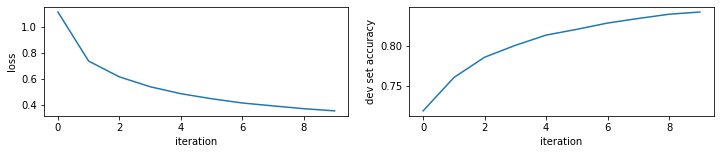

In [110]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

**Deliverable 5.3**: (*5 points*)
- As you can see from above, BiLSTM model performs worse than the Viterbi tagger.
- In the next section we'll use pretrained embeddings like the following to improve your performance.
- For now, tune the hyperparameters such that you obtain atleast `85.00%` accuracy on the dev set.
- You can try changing the no. of iterations, optimizers, no. of LSTM layers, the hidden dimension units, the FC layer dimensions, etc...
- **Tests**: ```test_bilstm.py: test_bilstm_dev_accuracy(), test_bilstm_test_accuracy()``` (you can't run this last one!)
        
**Remember: After training a model once, everytime when you rerun the train_model(...) function, the model is retrained on top of the previous parameters. If you want to start afresh, make sure the model is reinitialized and then trained.**

# Using cuda
If you want to run the code on a GPU: 
- make sure you convert the input and target Tensors to be cuda Variables like below:

`inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())`
- and convert your model to cuda:

 `model.cuda()`

The following links would be useful: when you want to run your model on a GPU:  
 - [pytorch_doc](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu)
 - [mnist pytorch gpu example](https://github.com/pytorch/examples/blob/master/mnist/main.py)

# 6. Using Word Embeddings

#### Extra Credit: Training Embeddings
Which word embeddings we use can make a significant difference in performance of NN-based NLP tasks. You will implement Word2Vec using the Continuous Bag of Words (CBOW) architecture pre-train your own embeddings from a dataset and compare it to pre-trained embeddings available on the internet. Once you're done with this, you might investigate skip-gram models and other approaches to learning word embeddings to cement your understanding.

**Deliverable 6.1**: (*5 Points*)
- The CBOW model learns to predict a word based on context of a pre-defined size. 
- Complete the ``cbow.build_context``function to build context vectors for a list documents.
- **Input**
    - List of tokenized documents.
    - Context size.
- **Output** 
    - List of (context, word) pairs, where context is a list containing the ``context_size`` words before and after ``word``. Note that no context is generated for words for which there is not ``context_size`` context available in the document. 
- **Tests**: ```test_cbow.py: test_build_context()```

In [ ]:
# We want our full vocabulary and word to index mapping.
vocab, word_to_ix = most_common.get_word_to_ix(TRAIN_FILE)
print ('words in the vocabulary: ',len(word_to_ix))

In [ ]:
reload(cbow)
print("Original Sentence: ", X_tr[5])
cbow.build_context([X_tr[5]], context_size=2)

Build context for the entire training dataset.

In [ ]:
training_context = cbow.build_context(X_tr, context_size=2)

**Deliverable 6.2**: (*5 points*)
- You will now implement the neural network model for training the CBOW, including the ``__init__`` method and the ``forward`` method.
- For this deliverable you will implement the ``__init__`` method. 
- Your model will have 5 parts:
    - ``self.embeddings`` - an ``nn.Embedding`` instance (see [nn.Embedding](https://pytorch.org/docs/stable/nn.html#embedding)) which will hold embeddings of size ``embedding_dim`` for each word in the vocabulary. 
    - ``self.linear1`` - A linear layer (see [nn.Linear](https://pytorch.org/docs/stable/nn.html#linear)) which each embedding will be fed in to, and whose output will be size 128. This is a hidden layer.
    - This linear layer will use the ReLU activation function (see [nn.ReLU](https://pytorch.org/docs/stable/nn.html#relu))
    - ``self.linear2`` - The output linear layer which will get input from the hidden layer and whose output will be the size of the vocabulary.
    - The output layer will use the LogSoftmax activation function (see [nn.LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)). 
- There is no test for this deliverable - simply make sure your output in the next block matches mine.


In [ ]:
reload(cbow)
cbow_embedding_dim = 64 # Output embedding size. 
cbow_model = cbow.CBOW(len(vocab), cbow_embedding_dim)
print(cbow_model)

**Deliverable 6.3**: (*5 Points*)
- For this deliverable you will implement the ``cbow.CBOW.forward`` method. 
- All this method has to do is:
    - Sum the embeddings for the inputs, and turn the result into a 1-dimensional tensor (hint: use ``view``)
    - Pass the result to ``linear1``, then its activation function.
    - Pass the result of the above to ``linear2``, then the softmax function.
    - Return the result.

Now it's time to train our CBOW model! This one is going to take quite a while if you aren't running it on a GPU with Cuda, so you might want to plan on running it overnight. You might try reducing the iterations to only a couple and adding a printout every thousand context vectors to make yourself a rough estimate for how long it'll take. I ran 25 iterations in about 3 hours in my run with CUDA on a GTX 1060.

If it'll take too long to run, you can run it only a few iterations and see how you do, then run it using my model trained on 25 iterations (load it from ``data/cbow_model_state_64_25.torch``). Be sure your trained model saves using the below code so I can check it later.

In [ ]:
device = "cpu" #change to cuda if you're using it!
cbow_model.to(device)
training_context_tensors = cbow.make_context_tensors(training_context, word_to_ix, device)

In [ ]:
cbow.train_model(cbow_model, training_context_tensors, word_to_ix, iters=25, lr=.001)

In [ ]:
# Change the filenames to better represent what you did - mine were 64 dimensional over 25 iterations.
cbow_model.to("cpu") # Move the model back to CPU if you've moded it for CUDA.
torch.save(cbow_model, "data/cbow_model_64_25_stu.torch")
torch.save(cbow_model.state_dict(), "data/cbow_model_state_64_25_stu.torch")
cbow.write_polyglot_format(cbow_model, word_to_ix, "data/cbow_model_polyglot_64_25_stu.pkl")

In [ ]:
# If you need to, you can re-load a CBOW state dictionary later rather than re-training it with the following:
cbow_model = cbow.CBOW(len(vocab), cbow_embedding_dim)
cbow_model.load_state_dict(torch.load("data/cbow_model_state_64_25_stu.torch", map_location=torch.device('cpu')))

In [ ]:
def cosine(emb1, emb2): #function to return the cosine similarity between the embeddings
    return emb1.dot(emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [ ]:
#word_embeddings = cbow_model.embeddings.numpy()
reload(cbow)

terw2v = cbow_model.get_word_emdedding('terrible', word_to_ix)[0].detach().numpy()
dirw2v = cbow_model.get_word_emdedding('dire', word_to_ix)[0].detach().numpy()
sucw2v = cbow_model.get_word_emdedding('success', word_to_ix)[0].detach().numpy()

print(sucw2v)
print(cosine(dirw2v,terw2v)) # dire and terrible are similar
print(cosine(dirw2v,sucw2v)) # dire and success aren't very similar
print(cosine(terw2v,sucw2v)) # terrible and success seem similar, why do you think?

Now let's test our embeddings!

In [ ]:
reload(bilstm)
torch.manual_seed(765);
embedding_dim=64
hidden_dim=30
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim, cbow_model.embeddings.to("cpu"))

In [ ]:
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=5, status_frequency=1, 
                                        optim_args = {'lr':0.01,'momentum':0}, param_file = 'best.params')

In [ ]:
bilstm.plot_results(losses, accuracies)

Our trained model Word2Vec didn't seem to do as well as without pre-trained embeddings. Why do you think this is? Let's try some other pre-trained embeddings to see if perhaps our embeddings just aren't very good. 

### Pretrained embeddings

- *Polyglot* provides pre-trained word embeddings for many languages
- You can download the english polyglot embeddings [here](https://sites.google.com/site/rmyeid/projects/polyglot).
- Use the following helper function to load in the polyglot embeddings, which you can use to initialize your parameter embeddings in your model. You need to make sure your embedding_dim matches your embeddings size.

In [ ]:
reload(bilstm)
filename = 'data/polyglot-en.pkl'
word_embeddings = bilstm.obtain_polyglot_embeddings(filename, word_to_ix)

- Let us have a look at these word embeddings. We can observe the cosine similarity between two word vectors.

In [ ]:
def cosine(emb1, emb2): #function to return the cosine similarity between the embeddings
    return emb1.dot(emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

In [ ]:
diremb = word_embeddings[word_to_ix['dire']]
teremb = word_embeddings[word_to_ix['terrible']]
succmb = word_embeddings[word_to_ix['success']]
print(word_embeddings[word_to_ix['success']])
print(cosine(diremb,teremb)) # dire and terrible are similar
print(cosine(diremb,succmb))
print(cosine(teremb,succmb))

We can already see these might be better than the ones we trained. Now, all we need to do is send in the word_embeddings when initializing your model

In [ ]:
torch.manual_seed(765);
embedding_dim=64
hidden_dim=30
model = bilstm.BiLSTM(len(word_to_ix),tag_to_ix,embedding_dim, hidden_dim, word_embeddings)

In [ ]:
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr,Y_tr, word_to_ix, tag_to_ix, 
                                        X_dv, Y_dv, num_its=10, status_frequency=2, 
                                        optim_args = {'lr':0.01,'momentum':0}, param_file = 'best.params')

In [ ]:
reload(bilstm)
bilstm.plot_results(losses, accuracies)

In [ ]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm-dev-en.preds', word_to_ix)

In [ ]:
print (scorer.accuracy(confusion))

In [ ]:
tagger_base.apply_model(model,'bilstm-te-en.preds',word_to_ix, all_tags, testfile=TEST_FILE_HIDDEN)

In [ ]:
# you don't have en-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(TEST_FILE,'bilstm-te-en.preds')
print (scorer.accuracy(te_confusion))

### Part of Speech Tagging for Norwegian
Make sure your code runs on the Norwegian dataset as well. You may want to use the pretrained embeddings for norwegian to improve the performance of the model. However, there is no deliverable or test for this part.
- Run the `BiLSTM` model on the norwegian dataset using the `BiLSTM` tagger. 

In [ ]:
#recalculating all_tags and tag_to_ix for the norwegian language
if START_TAG in all_tags_nr:
    all_tags_nr.remove(START_TAG)
if END_TAG in all_tags_nr:
    all_tags_nr.remove(END_TAG)

tag_to_ix_nr={}
for tag in all_tags_nr:
    if tag not in tag_to_ix_nr:
        tag_to_ix_nr[tag] = len(tag_to_ix_nr)

In [ ]:
#recalculating the vocab for the norwegian language: obtains the most common 7600 words from the file
vocab_nr, word_to_ix_nr = most_common.get_word_to_ix(NR_TRAIN_FILE, 7600)
print ('words in the vocabulary: ',len(word_to_ix_nr))
print (word_to_ix_nr[UNK])

- Loading training data for norwegian:

In [ ]:
reload(preprocessing);
X_tr_nr, Y_tr_nr = preprocessing.load_data(NR_TRAIN_FILE)

- Loading dev data for norwegian:

In [ ]:
X_dv_nr, Y_dv_nr = preprocessing.load_data(NR_DEV_FILE)

- Loading test data for norwegian:

In [ ]:
X_te_nr, Y_te_nr = preprocessing.load_data(NR_TEST_FILE_HIDDEN)

In [ ]:
#setting up the random seed
torch.manual_seed(765);

# initializing your model
embedding_dim=30
hidden_dim=30
model = bilstm.BiLSTM(len(word_to_ix_nr),tag_to_ix_nr,embedding_dim, hidden_dim)

In [ ]:
# training your model for norwegian data
loss = torch.nn.CrossEntropyLoss()
model, losses, accuracies = bilstm.train_model(loss, model, X_tr_nr,Y_tr_nr, word_to_ix_nr, tag_to_ix_nr, 
                                        X_dv_nr, Y_dv_nr, num_its=10, status_frequency=2, 
                                        optim_args = {'lr':0.2,'momentum':0}, param_file = 'best.params')

In [ ]:
reload(bilstm);
bilstm.plot_results(losses, accuracies)

In [ ]:
reload(tagger_base);
reload(bilstm);
confusion = tagger_base.eval_model(model,'bilstm-dev-nr.preds', word_to_ix_nr, 
                                   trainfile=NR_TRAIN_FILE, testfile=NR_DEV_FILE)

In [ ]:
print (scorer.accuracy(confusion))

In [ ]:
tagger_base.apply_model(model,'bilstm-te-nr.preds',word_to_ix_nr, all_tags_nr, 
                        trainfile=NR_TRAIN_FILE, testfile=NR_TEST_FILE_HIDDEN)

In [ ]:
# you don't have no_bokmaal-ud-test.conllu, so you can't run this
te_confusion = scorer.get_confusion(NR_TEST_FILE,'bilstm-te-nr.preds')
print (scorer.accuracy(te_confusion))

# 7. Improve Your Tagger!

**Deliverable 7.1** (*10 points*)
Improve your taggers performance to get atleast `91.00%` on the dev dataset for both English and Norwegian.
You can use any model that you have implemented in this assignment: HMM, or BiLSTM.
- HMM is unlikely to score high enough for full credit
- So, iterating on BiLSTM might be better.    
- Ideas: try varying the input (character-level features?), the optimizer, the model architecture, the pretrained embeddings, dropout, regularization, etc. Here are some more pretrained embeddings to try: [fastText](https://github.com/facebookresearch/fastText), [Polyglot](polyglot.readthedocs.io/en/latest/Embeddings.html), [word2vec](https://code.google.com/archive/p/word2vec/), [Glove](https://nlp.stanford.edu/projects/glove/).
- For Norwegian, there are officially [two written forms of language](https://en.wikipedia.org/wiki/Norwegian_language): `Bokmål` and `Nynorsk`. The dataset we are using is for the `Bokmål` language. So, when using pretrained embeddings make sure to use it for that specific form.

**Output files:** Make sure to name your files as follows: The unit tests will check for these files.
- `model-dev-en.preds` ( Predictions for the dev dataset of english ) 
- `model-te-en.preds`  ( Predictions for the test dataset of english ) 
- `model-dev-nr.preds` ( Predictions for the dev dataset of norwegian ) 
- `model-te-nr.preds`  ( Predictions for the test dataset of norwegian ) 

**Tests**: `test_performance.py`: 
- `test_en_dev_accuracy()`
- `test_en_test_accuracy()` #you cannot run this unit test.
- `test_nr_dev_accuracy()`
- `test_nr_test_accuracy()` #you cannot run this unit test.

## Rubric

Dev Set (both languages)
- $\geq$ 90.5% (*0.15 points*)
- $\geq$ 91.0% (*0.25 points*)

Test Set (both languages)
- $\geq$ 90.5% (*0.15 points*)
- $\geq$ 91.0% (*0.25 points*)


# 8. Compete! 

Try to get the best accuracy possible on both `English` and `Norwegian` tagging.

Some ideas:

- Better features, such as characters
- Better optimization
- Number of Layers and Hidden units in the BiLSTM
- More hidden layers in the Fully Connected Layer
- Better loss function: like structured perceptron
- Better preprocessing
- Using Pretrained Embeddings like [fastText](https://github.com/facebookresearch/fastText), [Polyglot](polyglot.readthedocs.io/en/latest/Embeddings.html), [word2vec](https://code.google.com/archive/p/word2vec/), [Glove](https://nlp.stanford.edu/projects/glove/)
- Dropout or other regularization scheme
- Go crazy and implement a Conditional Random Field!

**Output files:** Make sure to name your files as follows:

- `compete-dev-en.preds` ( Predictions for the dev dataset of english ) 
- `compete-te-en.preds`  ( Predictions for the test dataset of english ) 
- `compete-dev-nr.preds` ( Predictions for the dev dataset of norwegian ) 
- `compete-te-nr.preds`  ( Predictions for the test dataset of norwegian ) 

The unit tests will check for these files. To get the extra credit, you must submit these files.

**Rubric**

- Top 3 final score in English: +5%
- Top 3 final score in Norwegian: +5%
- Beat my best final score in English: +5%
- Best my best final score in Norwegian: +5%